In [22]:
import numpy as np
import bcolz
import cv2
import os
from os import path
import shutil
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from boltons.fileutils import mkdir_p
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dataset_dir = 'sessions'

In [24]:
sessions = [path.join(dataset_dir, x) for x in os.listdir(dataset_dir)]
sessions = [x for x in sessions if path.isdir(x)]

In [25]:
# im = Image.open(path.join(sessions[0], os.listdir(sessions[0])[0]))
# W, H = im.size
W = 75
H = 45
C = 1
CLASSES = 2
im.close()


In [26]:
cv2.setNumThreads(0)  # need to do this, or else...

def parse_file(session_dir, filename):
    img = cv2.imread(path.join(session_dir, filename), 0)
    crop_img = img[60:, 10:-10]
    
    edges = cv2.Canny(img, 100,200)
    edges = edges[60:, 10:-10]
    
    edges = cv2.resize(edges, (0,0), fx=0.25, fy=0.25) 
    crop_img = cv2.resize(crop_img, (0,0), fx=0.25, fy=0.25) 

    return crop_img, edges

def get_file_metadata(filename):
    _, idx, left, right = path.splitext(filename)[0].split('_')
    idx = int(idx)
    left = int(left)
    right = int(right)
    idx -= 1

    return (idx, (left, right))

def get_session_metadata(session_dir):
    files = os.listdir(session_dir)
    N = len(files)
    y = np.zeros((N,CLASSES))
    fnames = [None] * N
    for fname in os.listdir(session_dir):
        idx, pic_y = get_file_metadata(fname)
        y[idx, :] = pic_y
        fnames[idx] = fname

        
    return fnames, y
    


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np

import timeit

In [156]:
data = np.arange(40)
to_remove = [9,20]
mask = np.ones(len(data), dtype=bool)
for i in np.arange(4):
    mask[to_remove - i] = False
    mask[to_remove + i] = False    
    
data[mask,...]

np.argwhere(np.logical_or(data < 4, data < 5))

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [198]:
STEPS_WINDOW = 8
AFTER_PIVOT = STEPS_WINDOW * 3 // 4
BEFORE_PIVOT = STEPS_WINDOW - AFTER_PIVOT

class PinballEpisodePlayDataset(Dataset):
    def __init__(self, session_dir, transform=None):
        self.session_dir = session_dir
        self.transform = transform
        self.sample_names = os.listdir(session_dir)
        self.names, self.y = get_session_metadata(session_dir)
        self.flipped_idxes = np.squeeze(np.argwhere(np.logical_or(self.y[:, 0] > 0, self.y[:, 1] > 0)))
        
        N = len(self.y)
        
        mask = np.ones(N + AFTER_PIVOT, dtype=bool)
        
        for i in range(BEFORE_PIVOT):
            mask[self.flipped_idxes - i] = False

        for i in range(AFTER_PIVOT):
            mask[self.flipped_idxes + i] = False
        
        mask = mask[:-AFTER_PIVOT]
        self.non_flipped_idxes = np.arange(N)[mask,...]

    def __len__(self):
        return min(len(self.flipped_idxes), len(self.non_flipped_idxes)) * 2

    def __getitem__(self, idx):
        data = np.zeros((STEPS_WINDOW, H, W))
        y = np.zeros((CLASSES,))
        
        # even are flipped, odd are not
        dataset = self.flipped_idxes if idx %2 == 0 else self.non_flipped_idxes
        pivot_idx = dataset[idx // 2]
        
        for ii, sample_idx in enumerate(range(pivot_idx - BEFORE_PIVOT, pivot_idx + AFTER_PIVOT)):
            x_gray, x_edges = parse_file(self.session_dir, self.names[sample_idx])
            x = x_gray
            data[ii, :, :] = x
        
        y = self.y[pivot_idx]
                
        sample = (data, np.array(y))
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class PinballEpisodeMultiPlayDataset(Dataset):
    def __init__(self, sessions, transform=None):
        self.sessions_datasets = [PinballEpisodePlayDataset(x, transform) for x in sessions]
        self.total_len = sum(len(x) for x in self.sessions_datasets)
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        for s in self.sessions_datasets:
            if idx < len(s):
                return s[idx]
            else:
                idx -= len(s)
        
        raise Exception("Couldnt find index %d" % idx)
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        data, y = sample
        remapped = (torch.from_numpy(data),
                torch.from_numpy(y)
               )
        return remapped
        
    
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


transformed_dataset = PinballEpisodeMultiPlayDataset(sessions,
                                         transform=T.Compose([
#                                                Rescale(256),
#                                                RandomCrop(224),
                                               ToTensor()
                                         ]))

NUM_VAL = 200
NUM_TRAIN = len(transformed_dataset) - NUM_VAL

loader_train = DataLoader(transformed_dataset, batch_size=4, num_workers=8, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_val = DataLoader(transformed_dataset, batch_size=4, num_workers=8, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

print(len(transformed_dataset))


4816


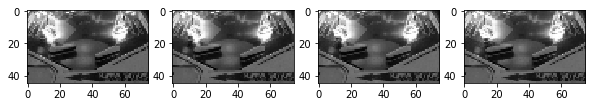

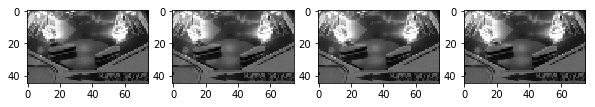

In [241]:
import random

x, y = transformed_dataset[random.randint(0, len(transformed_dataset) // 2) * 2]

def show_imgs(x):
    row_size = 4
    for pidx, s in enumerate(x):
        if pidx % row_size  == 0:
            p = plt.figure()
        p.add_subplot(1,4, (pidx % row_size) + 1)
        plt.imshow(x[pidx].numpy(), cmap='gray')

    plt.show()

show_imgs(x)

In [194]:
dtype = torch.FloatTensor # the CPU datatype

print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
# Here's where we define the architecture of the model... 
simple_model = nn.Sequential(
                nn.BatchNorm2d(STEPS_WINDOW),
                nn.Conv2d(STEPS_WINDOW, 32, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(32, 64, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                Flatten(),
                nn.Linear(768, CLASSES), # affine layer
              )

# Set the type of all data in this model to be FloatTensor 
simple_model.type(dtype)

loss_fn = nn.MSELoss().type(dtype)
optimizer = optim.RMSprop(simple_model.parameters(), lr=1e-3) # lr sets the learning rate of the optimizer

In [195]:
simple_model.train()

def train_epoch():
    # Load one batch at a time.
    for t, (x, y) in enumerate(loader_train):
        x_var = Variable(x.type(dtype))
        y_var = Variable(y.type(dtype))

        # This is the forward pass: predict the scores for each class, for each x in the batch.
        scores = simple_model(x_var)

        # Use the correct y values and the predicted y values to compute the loss.
        loss = loss_fn(scores, y_var)

        if (t + 1) % 100 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

        # Zero out all of the gradients for the variables which the optimizer will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with respect to each 
        # parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients computed by the backwards pass.
        optimizer.step()

In [196]:
train_epoch()


t = 100, loss = 0.0757
t = 200, loss = 0.1102
t = 300, loss = 0.0704
t = 400, loss = 0.0410
t = 500, loss = 0.1057
t = 600, loss = 0.0294
t = 700, loss = 0.0198
t = 800, loss = 0.0143
t = 900, loss = 0.0032
t = 1000, loss = 0.0021
t = 1100, loss = 0.0291


In [197]:

def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True)
        scores = model(x_var)
        scores[scores>0.5] = 1
        scores[scores<=0.5] = 0
        scores = scores.double()
        num_correct += (scores.data == y).sum() / CLASSES
        num_samples += scores.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

simple_model.eval()    

check_accuracy(simple_model, loader_val)

Got 198 / 200 correct (99.25)


scores [[ 1.  1.]]
y [ 1.  0.]
num_correct 1


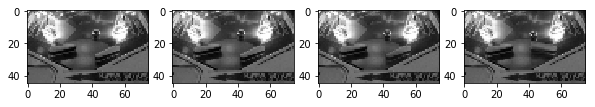

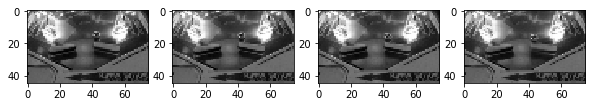

scores [[ 1.  1.]]
y [ 1.  0.]
num_correct 1


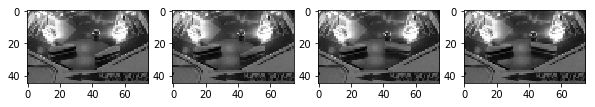

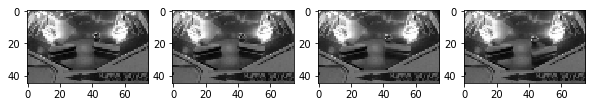

In [240]:
for x, y in loader_val:
    for i in range(len(x)):
        x_var = Variable(torch.unsqueeze(x[i], 0).type(dtype))
        scores = simple_model(x_var)
        scores[scores>0.5] = 1
        scores[scores<=0.5] = 0
        scores = scores.double()
        
        num_correct = (scores.data == y[i]).sum()
        if num_correct < 2:
            print('scores', scores.data.numpy())
            print('y', y[i].numpy())
            print('num_correct', num_correct)
            show_imgs(x[i].numpy())    
            
    break
        